<a href="https://colab.research.google.com/github/Kunslog/ML_summer_Sep_25/blob/main/template_bandits_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# #3 Multiarmed bandits

**Oxford University Economics Summer School 2025, Foundations of Machine Learning**

*Johanna Barop, 2025*


This is a *Google Colab document*. Think of Google Colab as "Google Docs for Jupyter" ✨. It's basically a *Jupyter Notebook* (which allows you to combine markdown text cells and code cells) integrated into your *Google Drive*.

We will use Google Colab for all tutorials, so you can code directly in your browser without installing any software or Python packages, and make use of Colab's free GPUs.

## **Question 1:** Thompson sampling for the Bernoulli bandit problem

### Bernoulli bandit problem
Consider a **Bernoulli bandit problem** with $k$ treatments $D_t \in \{1, \ldots, k\}$, time-invariant treatment effects $\theta = (\theta^1, \ldots, \theta^k) \sim U([0, 1]^k)$, binary outcomes $Y_t = Y^{D_t} \in \{0, 1 \}$ and potential outcomes $Y_t^d \sim Ber(\theta^d)$. Let treatment be assigned by *Thompson sampling* with a uniform prior $\hat\theta_1 = (\hat\theta_1^1, \ldots, \hat\theta_1^k) \sim U([0, 1]^k)$.

### Thompson sampling
**Thompson sampling** is a stochastic algorithm for identifying the optimal treatment $d^*$. Intuitively the algorithm assigns treatment $d$ with the probability that $d$ is optimal. It achieves exploration by playing the treatment arm with the highest sampled mean $\hat\theta^d_t$. Notably the assignment probability depends only on the sampled mean, not on the number of times an arm has been played previously. Given the history $(D_1, \ldots, D_{t-1}, Y_1, \ldots, Y_{t-1})$, Thompson sampling assigns the treatment with the largest probability of success $\hat\theta_t^d$: $$
D_{t} = \text{argmax}_d \; \hat\theta_{t}^d
$$ It then records treatment $D_t$ and outcome $Y_t$ and updates $\hat\theta_{t+1}$ by drawing from the posterior distribution. In the binomial case with uniform priors, the posterior follows a *beta distribution*. $$
\begin{aligned}
\hat\theta^d_{t+1} &\sim Beta(\alpha_{t+1}^d, \beta_{t+1}^d) \; \text{ with} \\
\alpha_{t+1}^d &= 1 + T^d_{t+1} \cdot \overline Y^d_{t+1} \\
\beta_{t+1}^d &= 1 + T^d_{t+1} \cdot (1 - \overline Y^d_{t+1}) \; \text{ where}
\end{aligned}
$$ $$
\\T^d_{t+1} = \sum_{1\leq s \leq t} 1\{D_s = d\} \; \text{and} \; \overline Y^d_{t+1} = \frac{1}{T_{t+1}^d}\sum_{1\leq s \leq t} 1\{D_s = d\} \cdot Y_s
$$ $T^d_{t+1}$ is the number of times treatment $d$ was assigned until $t$ and $\overline Y^d_{t+1}$ is the average outcome for treatment $d$ up until time $t$. Thus you can think of $T^d_{t+1} \cdot \overline Y^d_{t+1}$ as the number of past successes for a given treatment $d$, and of $T^d_{t+1} \cdot (1 - \overline Y^d_{t+1})$ as the number of pastfailures for that treatment.

Thompson sampling initially assumes $\hat\theta^d \sim Beta(1, 1)$ for treatment arm $d$, which is natural because $Beta(1,1)$ reduces to the uniform distribution on $[0, 1]$. The higher $\alpha_t$ and $\beta_t$, the tighter the concentration of the posterior around the mean. Thus as arm $d$ is played more often, the beta distribution becomes more concentrated around the empirical mean. For a trial resulting in a success, $\alpha_{t+1}$ increases; for a failure, $\beta_{t+1}$ increases. Updating $\alpha$ and $\beta$ therefore increases the confidence in our treatment effect estimates.

### Relation to shrinkage and regularization
Recall that the mean of the beta distribution is $$
E[\hat\theta_{t+1}] = \frac{\alpha_{t+1}}{\alpha_{t+1} + \beta_{t+1}} = \frac{1+ T_{t+1} \cdot \overline Y_{t+1}}{2+ T_{t+1}} = \frac{1+ \sum_{1\leq s \leq t+1} 1\{D_s = 1\} \cdot Y_s^d}{2+ \sum_{1\leq s \leq t+1} 1\{D_s = 1\}}
$$ which is a *linear shrinkage estimator* of the treatment effect.

Compared to the mean of historically observed outcomes $\frac{\sum_{1\leq s \leq t+1} 1\{D_s = 1\} \cdot Y_s^d}{\sum_{1\leq s \leq t+1} 1\{D_s = 1\}}$, drawing from the beta distribution performs regularization, which improves predictive performance.

α is past success.
β is past failure.


### Setup

In [16]:
# Import packages.
import numpy as np
from scipy.stats import beta      # to plot beta distributions
import matplotlib.pyplot as plt

# Set default plot style to look like R's ggplot.
plt.style.use('ggplot')

# Set the seed.
np.random.seed(12345)

### The Beta distribution

Note how larger $\alpha$ and $\beta$ condense the beta distribution around its mean. As we repeatedly draw one treatment arm, we get more confident in our estimate of $\theta^d$ (no matter whether it results in a success or a failure). This is reflected in updating and increasing $\alpha$ and $\beta$.

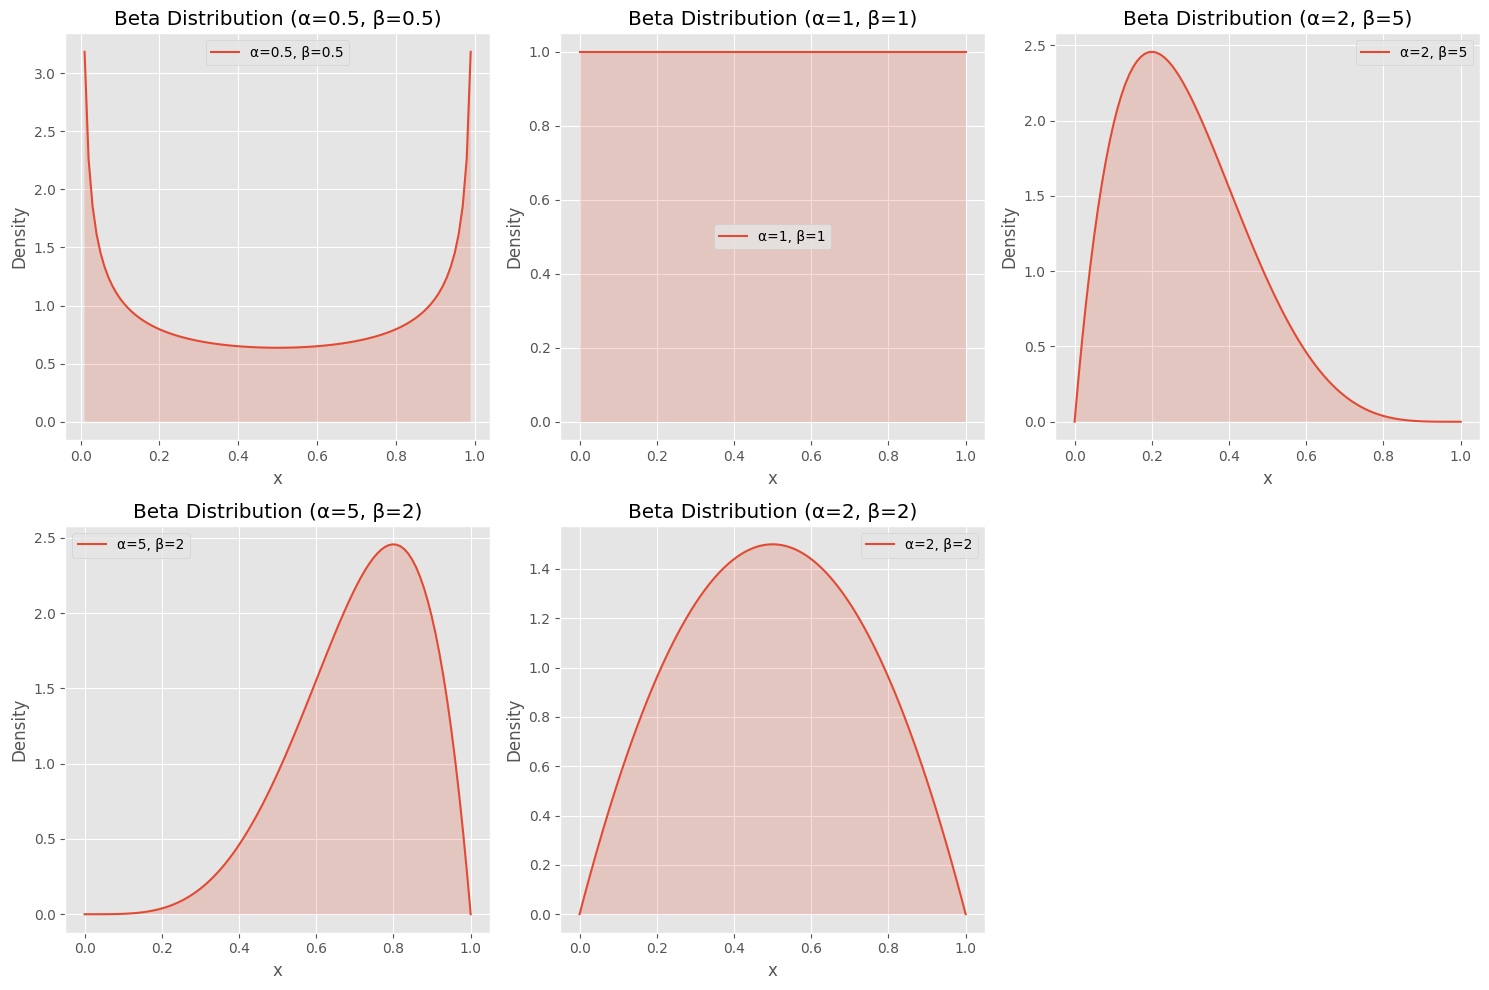

In [17]:
# @title The beta distribution and its parameters

# Define a function to plot the Beta distribution
def plot_beta_distribution(a, b, ax):
    # Create a range of values between 0 and 1.
    x = np.linspace(0, 1, 100)
    # Compute the Beta distribution for the given alpha and beta.
    y = beta.pdf(x, a, b)
    # Plot the distribution
    ax.plot(x, y, label=f'α={a}, β={b}')
    ax.fill_between(x, y, alpha=0.2)
    ax.set_title(f'Beta Distribution (α={a}, β={b})')
    ax.set_xlabel('x')
    ax.set_ylabel('Density')
    ax.legend()

# List of alpha and beta parameters to plot.
parameters = [(0.5, 0.5), (1, 1), (2, 5), (5, 2), (2, 2)]

# Create subplots for visualizing different alpha and beta values.
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
axes = axes.flatten()

# Generate plots for each combination of alpha and beta.
for i, (a, b) in enumerate(parameters):
    plot_beta_distribution(a, b, axes[i])

# Remove the empty subplot.
fig.delaxes(axes[-1])

# Adjust layout.
plt.tight_layout()
plt.show()

### 1) a)

Set up a function which accepts a sample size T and a $k$-vector $(\theta^1, ... , \theta^k)$ as
its arguments, and returns a history $(D_t, Y_t)_{t=1}^T$ generated based on the Bernoulli
bandit model and Thompson sampling.

#### Mini example TS 1

To start, consider a minimal example with $k=3$ treatments. Suppose the algorithm has been running for a bit. We will compute the next step recommend by the Thompson sampling algorithm.

Below, I defined the vectors `treatments` and `outcomes` that contain a history of the algorithm's past treatment decisions $D_t$ and their outcomes $Y_t$ (failures `0` and successes `1`). Compute $\alpha_{t+1}$ and $\beta_{t+1}$ based on them, and draw from the posterior distribution to update the vector of your treatment effect estimates $\theta$. Select the next treatment as the maximum of that vector. The use the binomial distribution to predict the outcome of that treatment, using the true `theta`.  

In [18]:
"""Mini example TS 1"""
k = 3
theta      = np.array([.6, .4, .2]) # the true treatment effects. They don't have to add up to 1!
treatments = np.array([0, 1, 0, 1, 2, 0, 2])
outcomes   = np.array([1, 0, 1, 1, 0, 1, 0])

# Stop here and think:
  # What is the optimal treatment?
  # Based on past successes and failures, would Thompson sampling pick option 0, 1, or 2 next?

# Compute the number of successes and failures for each treatment.
treatment_1 = (treatments == 0).sum()
treatment_2 = (treatments == 1).sum()
treatment_3 = (treatments == 2).sum()

display(treatment_1)
display(treatment_2)
display(treatment_3)

# Compute alpha and beta.
average_treatment_1 = outcomes[treatments == 0].mean()
average_treatment_2 = outcomes[treatments == 1].mean()
average_treatment_3 = outcomes[treatments == 2].mean()

display(average_treatment_1)
display(average_treatment_2)
display(average_treatment_3)

alpha_1 = 1 + treatment_1 * average_treatment_1
beta_1  = 1 + treatment_1 * (1 - average_treatment_1)

alpha_2 = 1 + treatment_2 * average_treatment_2
beta_2  = 1 + treatment_2 * (1 - average_treatment_2)

alpha_3 = 1 + treatment_3 * average_treatment_3
beta_3  = 1 + treatment_3 * (1 - average_treatment_3)

alpha = [alpha_1, alpha_2, alpha_3]
beta  = [beta_1, beta_2, beta_3]

# Draw from the posterior distribution np.random.beta() to update treatment effect estimates.
beta_post = np.random.beta(alpha, beta)
print(beta_post)
# How similar is your posterior to your prior?

# Select the next treatment as the one with the highest probability of success.

# Predict the outcome of that treatment using np.random.binomial().

# ---------------------------------------------------------------------------
# Compute the number of successes and failures for each treatment.
successes = np.array([np.sum(    outcomes[np.equal(treatments, d)]) for d in range(k)])
failures  = np.array([np.sum(1 - outcomes[np.equal(treatments, d)]) for d in range(k)])

# Compute alpha and beta.
alpha = 1 + successes
beta  = 1 + failures

# Draw from the posterior distribution np.random.beta() to update treatment effect estimates.
posterior_draw = np.random.beta(alpha, beta)
print(f"posterior: {posterior_draw}")

# How similar is your posterior to your prior?

# Select the next treatment as the one with the highest probability of success.
next_treat = np.argmax(posterior_draw)
print(f"next arm: {next_treat}")
print(f"optimal arm?: {next_treat == np.argmax(theta)}")

# Predict the outcome of that treatment using np.random.binomial().
next_outcome = np.random.binomial(1, theta[next_treat])
print(f"next outcome: {next_outcome}")

# ---------------------------------------------------------------------------



np.int64(3)

np.int64(2)

np.int64(2)

np.float64(1.0)

np.float64(0.5)

np.float64(0.0)

[0.9349338  0.50490834 0.32881085]
posterior: [0.74319289 0.13928172 0.10254729]
next arm: 0
optimal arm?: True
next outcome: 1


Now define the function `thompson(outcomes, treatments, k)` based on the example above. It should select the next-period treatment based on a history of past outcomes.

In [19]:
# Define thompson(outcomes, treatments, k).

def thompson(outcomes, treatments, k):
    '''Given a vector of binary outcomes and discrete treatments,
        Thompson sampling selects the next treatment.'''

    successes = np.array([np.sum(    outcomes[np.equal(treatments, d)]) for d in range(k)]) # count the successes for each d
    failures  = np.array([np.sum(1 - outcomes[np.equal(treatments, d)]) for d in range(k)])

    posterior_draw = np.random.beta(1 + successes, 1 + failures)

    return np.argmax(posterior_draw) # Select the next treatment as the one with the highest probability of success.

# Check if it works on mini example 1. Does it return the correct next-period treatment?
thompson(outcomes, treatments, k)


np.int64(0)

In [20]:
# Check if it works on mini example 1. Does it return the correct next-period treatment?


#### Mini example TS 2

Let's do another mini-Thompson example. For a given `theta` and $T=25$, use `thompson(outcomes, treatments, k)` to compute an array of
- the treatment
- whether the right treatment is selected
- the outcome,
- outcomes, and the treatment effect of the treatment chosen
for every period.

**Hint:** iterate `thompson(outcomes, treatments, k)` $T$ times, and use your code snippet from above that predicts the outcome.

In [21]:
"""Mini example TS 2"""
T = 25
theta = np.array([.6, .3, .9, .7, .1, 0])

# Define k using len().
k = len(theta)

# Initialise the history: Create three empty np-arrays of length T for treatments,
# whether the optimal arm is selected, and outcomes.
treatment = np.empty(T, dtype = np.int8)
outcome   = np.empty(T, dtype = np.int8)
opt_arm   = np.empty(T, dtype = np.int8)

d_star = np.argmax(theta)

# Create a for-loop that computes the treatment for each period (using thompson())
# and predicts the outcome, filling in the empty treatment and outcome arrays.
for t in range(T):
    treatment[t] = thompson(outcome[range(t-1)], treatment[range(t-1)], k)
    opt_arm[t]   = treatment[t] == d_star
    outcome[t]   = np.random.binomial(1, theta[treatment[t]])
print(f"treatment   : {treatment}")
print(f"outcome     : {outcome}")
print(f"optimal arm?: {opt_arm}")

# Create an array of the true treatment effect for each period.
true_th = theta[treatment]
print(f"true_th     : {true_th}")

# Double-check if your code works for the first period where we start with alpha = beta = 1!
# Does Thompson sampling converge on the optimal treatment in 25 periods?

# Define simulate_thompson_path(theta, T).
def simulate_thompson_path(theta, T):
    '''Given a vector of expected potential outcomes,
        simulate a path of outcomes and treatments according to Thompson sampling.'''

    # Initialise the history.
    k = len(theta)
    d_star = np.argmax(theta)

    treatment = np.empty(T, dtype = np.int8)
    outcome   = np.empty(T, dtype = np.int8)
    opt_arm   = np.empty(T, dtype = np.int8)

    # for each period:
    for t in range(T):
        treatment[t] = thompson(outcome[range(t-1)], treatment[range(t-1)], k) # identify the treatment using thompson()
        outcome[t]   = np.random.binomial(1, theta[treatment[t]]) # record its outcome using binomial sampling
        opt_arm[t]   = treatment[t] == d_star

    return np.array([treatment, outcome, opt_arm, theta[treatment]]) # the history.

# Check if it works on mini example 2.
# (Note that it will return a different history because we draw from the binomial
# distribution, but the structure of the arrays should be the same.)
simulate_thompson_path(theta, T)

treatment   : [5 1 3 1 1 2 3 2 4 1 4 2 2 2 3 2 2 2 2 2 2 2 2 2 2]
outcome     : [0 1 1 0 0 1 0 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
optimal arm?: [0 0 0 0 0 1 0 1 0 0 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1]
true_th     : [0.  0.3 0.7 0.3 0.3 0.9 0.7 0.9 0.1 0.3 0.1 0.9 0.9 0.9 0.7 0.9 0.9 0.9
 0.9 0.9 0.9 0.9 0.9 0.9 0.9]


array([[1. , 0. , 3. , 2. , 5. , 0. , 0. , 2. , 0. , 4. , 2. , 5. , 2. ,
        2. , 2. , 0. , 0. , 2. , 2. , 2. , 2. , 2. , 2. , 2. , 0. ],
       [0. , 1. , 0. , 1. , 0. , 0. , 1. , 1. , 1. , 0. , 1. , 0. , 1. ,
        0. , 1. , 0. , 1. , 1. , 1. , 1. , 0. , 1. , 1. , 1. , 1. ],
       [0. , 0. , 0. , 1. , 0. , 0. , 0. , 1. , 0. , 0. , 1. , 0. , 1. ,
        1. , 1. , 0. , 0. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 0. ],
       [0.3, 0.6, 0.7, 0.9, 0. , 0.6, 0.6, 0.9, 0.6, 0.1, 0.9, 0. , 0.9,
        0.9, 0.9, 0.6, 0.6, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.6]])

Now define the function `simulate_thompson_path(theta, T)` based on the example above. It should return an array of
- the treatments,
- outcomes,
- whether the righ treatment was selected,
- and true treatment effects
for each treatment chosen on the path.

Check if it works on mini example 2.

In [22]:
# Define simulate_thompson_path(theta, T).

In [23]:
# Check if it works on mini example 2.
# (Note that it will return a different history because we draw from the binomial
# distribution, but the structure of the arrays should be the same.)

### 1) b)

Write a second function which takes the same arguments, plus a number of replications R, and evaluates the first function R times (using parallel computing).
This function should return the average (across simulation runs) of
* $Y_t$,
* $D_t$,
* whether the right treatment was selected $1\{D_t = d^*\}$
* the treatment effect of the treatment chosen $\theta^{D_t}$

for each time period $t$.

To solve this, we will iterate `simulate_thompson_path()`. This becomes very computationally expensive for a large number of repetitions, so we will use *parallel computing*.

#### Parallel computing and CPUs in Colabs

[Core parallelisation](https://en.wikipedia.org/wiki/Parallel_computing) makes use of **all** the CPUs in your laptop, splitting up your computing tasks over them. This works particularly well if the tasks are independent of each other. We call this [*embarrassingly parallel*](https://en.wikipedia.org/wiki/Embarrassingly_parallel) tasks.

If you have four CPUs, your code will run (almost) four times as fast! (Not quite four times as fast because typically some workload threads don't parallelise, that's [*Amdahl's law*](https://en.wikipedia.org/wiki/Amdahl%27s_law)).

To do core parallelisation in Python, you can use the `multiprocess` package (you will need to `pip install` it). Check out its documentation [here](https://pypi.org/project/multiprocess/) if you're stuck!

To check how many core you have to work with, run this code (on your device locally or on Colabs):

In [24]:
# Install the multiprocess package. It is a fork of the multiprocessing package and cannot be used directly.
# We're using it here because it saves us headaches when serialising a function with several inputs.
!pip install multiprocess
import multiprocess

# Count the number of cores.
cores = multiprocess.cpu_count()
cores

2

Colabs gives you 2 cores. Laptops will normally have 2 or 4 cores, some gaming laptops will have 10+ (because parallel computing is important for video graphics).

You can also change the CPU that Colabs is running on under runtime → change runtime type. See this [medium article](https://drlee.io/choosing-the-right-colab-runtime-a-guide-for-data-scientists-and-analysts-57ee7b7c9638) for a guide. For the purpose of this problem set, the standard CPU is fine.

We will now use parallel computing to simulate multiple repetitions of Thompson sampling.

#### Mini example TS 2 (Part 2)

Building on mini example 2, repeat `simulate_thompson_path(theta, T)` 1,000 times. Store your results, and compute their means across simulation runs for each $t$.

**Hint:** You can combine `multiprocess` and anonymous `lambda`functions like this to speed up parallel tasks:


In [25]:
def serialise_me(x, y):
  return x + y

pool  = multiprocess.Pool()
iterations = pool.map(lambda _: serialise_me(3, 4), range(10)) # multiprocess plays well with anonymous lambda functions

print(iterations)

[7, 7, 7, 7, 7, 7, 7, 7, 7, 7]


Now complete the second part of the mini example.

In [26]:
"""Mini example 2 - Part 2"""
T = 25
theta = np.array([.6, .3, .9, .7, .1, 0])
reps = 1000

# Use the multiprocess package to repeat simulate_thompson_path 10000 times.

iterations = pool.map(lambda _: simulate_thompson_path(theta, T), range(10000)) # multiprocess plays well with anonymous lambda functions

# print(iterations)

# Compute the mean for each period t.

# ------------------------------------------------------------------------------
T = 25
theta = np.array([.6, .3, .9, .7, .1, 0])
reps  = 1000

# Use the multiprocess package to repeat simulate_thompson_path 1000 times.
paths = pool.map(lambda _: simulate_thompson_path(theta, T), range(reps))

# Compute the mean for each period t.
np.array(paths).mean(axis = 0)

# Define average_thompson_path(theta, T, reps = 10000).
def average_thompson_path(theta, T, reps = 10000):
    '''Simulate reps, replicate Thompson paths.'''

    # Use the multiprocess package to repeat simulate_thompson_path 10000 times.
    pool  = multiprocess.Pool()
    paths = pool.map(lambda _: simulate_thompson_path(theta, T), range(reps))

    return np.array(paths).mean(axis = 0) # compute means for each column (period).

# Check if it works on mini example 2.
average_thompson_path(theta, T)

array([[2.5054 , 2.5166 , 2.4184 , 2.3212 , 2.298  , 2.2024 , 2.1812 ,
        2.118  , 2.1052 , 2.0916 , 2.0702 , 2.0736 , 2.0234 , 2.0634 ,
        2.0372 , 2.0312 , 2.0202 , 2.0004 , 2.0184 , 2.0082 , 2.018  ,
        2.022  , 2.0066 , 2.0062 , 1.9956 ],
       [0.435  , 0.4304 , 0.475  , 0.4934 , 0.515  , 0.5402 , 0.5558 ,
        0.589  , 0.6046 , 0.634  , 0.651  , 0.6618 , 0.6616 , 0.6844 ,
        0.6954 , 0.6956 , 0.7034 , 0.7094 , 0.7264 , 0.7372 , 0.7484 ,
        0.7646 , 0.76   , 0.7544 , 0.76   ],
       [0.1694 , 0.1576 , 0.1944 , 0.2118 , 0.2278 , 0.261  , 0.28   ,
        0.3024 , 0.3286 , 0.36   , 0.3732 , 0.4152 , 0.424  , 0.4566 ,
        0.458  , 0.4808 , 0.4974 , 0.5038 , 0.526  , 0.5384 , 0.5544 ,
        0.5682 , 0.5862 , 0.6026 , 0.6036 ],
       [0.43476, 0.42884, 0.46286, 0.49048, 0.51212, 0.54402, 0.56226,
        0.59268, 0.60562, 0.62748, 0.64594, 0.66206, 0.672  , 0.68822,
        0.69122, 0.7018 , 0.71052, 0.71536, 0.7242 , 0.73318, 0.74124,
        0.747

Now define the function `average_thompson_path(theta, T, reps = 10000)` based on your example above and test it for the mini example.

**Hint:** To test your function, you might initially want to use fewer simulation `reps` to save time.

In [27]:
# Define average_thompson_path(theta, T, reps = 10000).

# Check if it works on mini example 2.


### 1) c)

Pick a fixed vector of parameters $(\theta^1, ... , \theta^k)$ and a time horizon $T$ and use the second function to plot the average (across replications) of *cumulative average regret* (or *finite horizon regret*)

$$
\overline R_T = \frac{1}{T} \sum_{t=1}^T \bigl[ (\text{max}_d \; \theta^d) - \theta^{D_t}\bigr] = \frac{1}{T} \sum_{t=1}^T \Delta^{D_t} = \frac{1}{T} \sum_d T^d_T \cdot \Delta^d
$$

as a function of $T$, using a large number of replications $R$ (such as $R = 10.000$).

Repeat this for several different choices of $(\theta^1, ... , \theta^k)$. How does the result relate to the theoretical regret rate bound discussed in the lecture, and to Agrawal and Goyal (2012)?

#### Theoretical regret bounds

##### **Lower bound**
Lai and Robbins (1985) proof that Thompson sampling has the following **lower bound** on cumulative average regret $\overline R_T$:

$$
\overline R_T \geq \bigl[\sum_{d \neq d^*} \frac{\Delta^d}{\text{kl}(\theta^d, \theta^*)} + o(1) \bigr] \frac{\log(T)}{T}
$$

with *Kullback-Leibler divergence*

$$
\text{kl}(\theta^d, \theta^*) = \theta^d \cdot \log\bigl(\frac{\theta^d}{\theta^*}\bigr) + (1-\theta^d) \cdot \log\bigl(\frac{1-\theta^d}{1-\theta^*}\bigr)
$$

This bound holds $\theta$ constant as $T \rightarrow \infty$. This provides a good characterisation of Thompson sampling for the *high-powered case*, i.e. for a large number of observations $T$ relative to the treatment size $\Delta^d$. No adaptive algorithm can achieve a better regret bound than this $\log T$ rate.

##### ***Upper bound***
Agrawal and Goyal (2012) give an **upper bound** for regret. They show that Thompson sampling achieves logarithmic expected regret. For the stochastic $k$-armed bandit, expected cumulative regret has an upper bound of order

$$
E[\overline R_T] \leq O\bigl( \big[\sum_{d \neq d^*} \frac{1}{(\Delta^d)^2} \bigr]^2  \frac{\log( T)}{T} \bigr)
$$

Thompson sampling satisfies both theoretical bounds. **Expected cumulative regret converges.** It approaches the lower regret bound derived by Lai and Robbins (1985) as $t \rightarrow \infty$.


[o and O are notation from statistics]

g(x)= O (g(x)) for x -> inf

#### Convergence and choice of prior

Let's see how convergence depends on our choice of the prior $\theta$! Below, create plots different priors theta, setting $T=80$. Use the function `average_thompson_path()` we defined above.

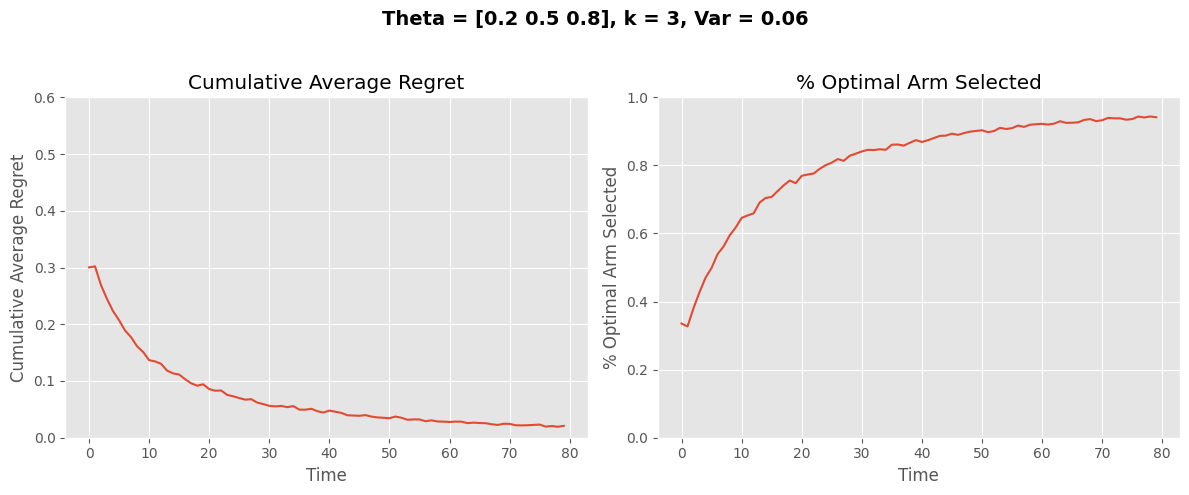

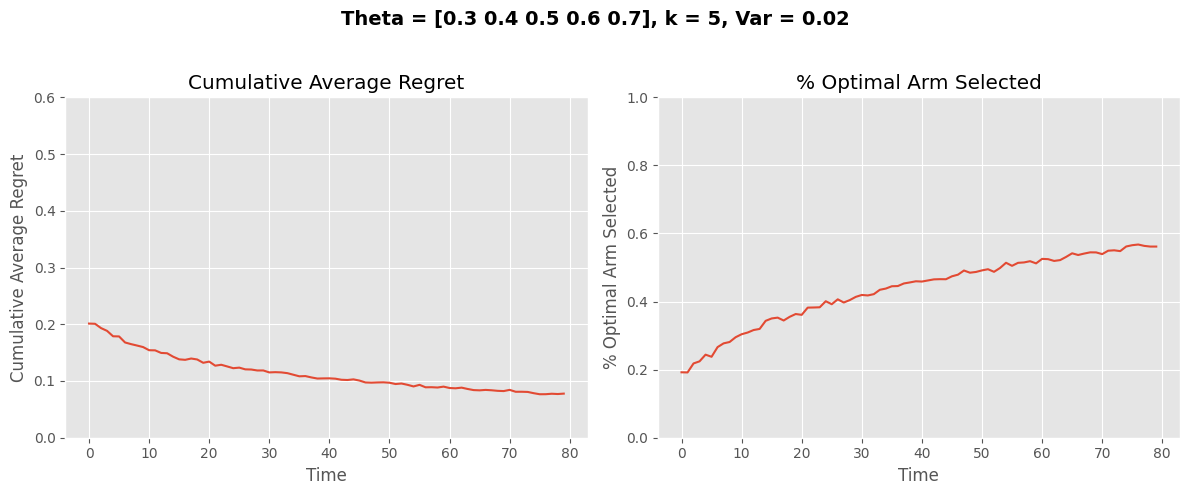

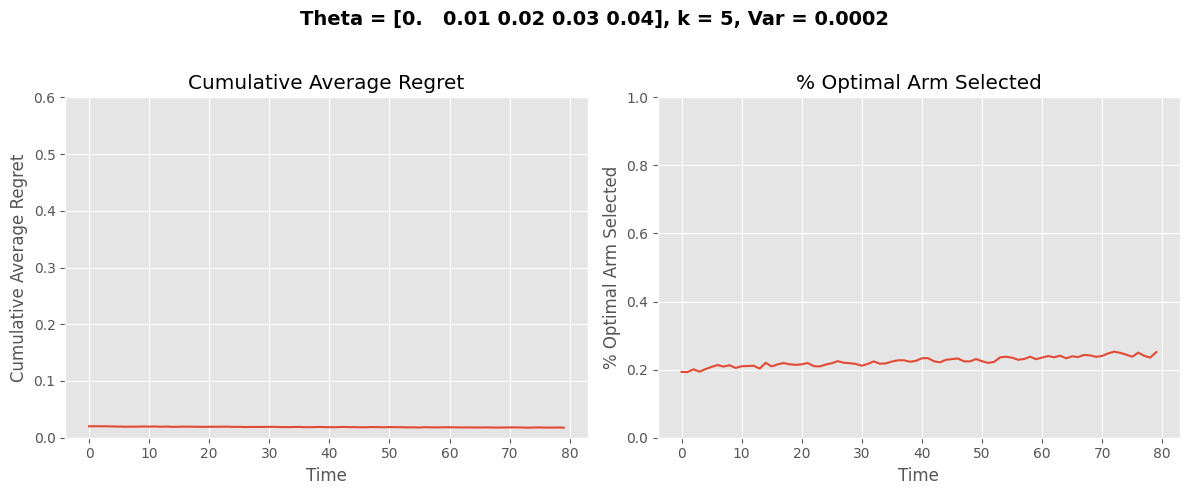

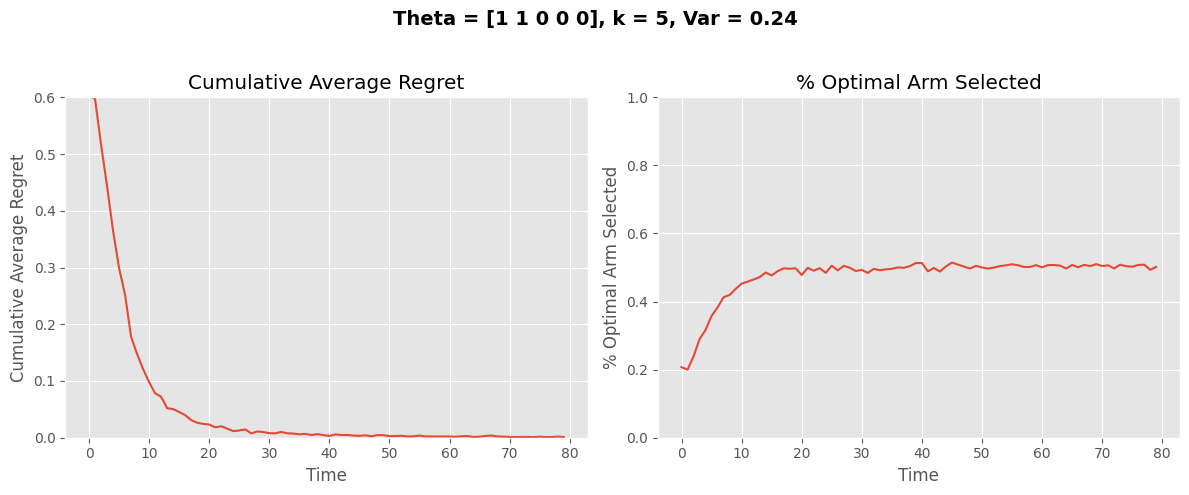

In [28]:
# Since we'll create multiple plots, its convenient to set the plotting parameters
# inside a function.

# To code this up, you might want to start with creating one plot for
# Define average_thompson_path(theta, T, reps = 10000).
def average_thompson_path(theta, T, reps = 10000):
    '''Simulate reps, replicate Thompson paths.'''

    # Use the multiprocess package to repeat simulate_thompson_path 10000 times.
    pool  = multiprocess.Pool()
    paths = pool.map(lambda _: simulate_thompson_path(theta, T), range(reps))

    return np.array(paths).mean(axis = 0) # compute means for each column.

# Check if it works on mini example 2.
#average_thompson_path(theta, T)

# Since we'll create multiple plots, its convenient to set the plotting parameters
# inside a function.
def plot_results(avg_thompson, theta, T):
    best_arm = avg_thompson[2]            # third entry in the array is the % across runs when TS selects the right arm
    regret = max(theta) - avg_thompson[3] # fourth entry in the array is the average effect of the arm chosen for each t

    fig, axes = plt.subplots(1, 2, figsize=(12, 5)) # axes object allow you to control where the global plot goes

    # Plot Cumulative Average Regret
    axes[0].plot(range(T), regret)
    axes[0].set_ylim(0, 0.6)
    axes[0].set_xlabel('Time')
    axes[0].set_ylabel('Cumulative Average Regret')
    axes[0].set_title(f'Cumulative Average Regret')

    # Plot % Optimal Arm Selected
    axes[1].plot(range(T), best_arm)
    axes[1].set_ylim(0, 1)           # force y-axis between 0 and 1
    axes[1].set_xlabel('Time')
    axes[1].set_ylabel('% Optimal Arm Selected')
    axes[1].set_title(f'% Optimal Arm Selected')

    # Global plotting parameters
    fig.suptitle(f'Theta = {theta}, k = {len(theta)}, Var = {round(np.var(theta), 4)}', fontsize=14, fontweight='bold')

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Visualise this vector over time.
# First plot
T = 80
theta_1 = np.array([0.2, 0.5, 0.8])
TS_1 = average_thompson_path(theta_1, T)
plot_results(TS_1, theta_1, T)

# Second plot
theta_2 = np.array([.3,.4,.5,.6,.7])
TS_2 = average_thompson_path(theta_2, T)
plot_results(TS_2, theta_2, T)

# Third plot
theta_3 = np.array([0, 0.01, 0.02, 0.03, 0.04])
TS_3 = average_thompson_path(theta_3, T)
plot_results(TS_3, theta_3, T)

# Fourth plot
theta_4 = np.array([1, 1, 0, 0, 0])
TS_4 = average_thompson_path(theta_4, T)
plot_results(TS_4, theta_4, T)


# If you have a plot, try to generalise your code and define the function
# plot_average_thompspon_path(avg_thompson, theta, T) where avg_thompson is the
# output of average_thompson_path().


Play around with your function, try out different $\theta$! Look for systematic patterns. How do convergence patterns change for

1. different $k$ and
2. different prior variances $Var(\theta)$?

### 1) d)

Now let $k = 2$, fix $\theta_1 = .5$ and $T = 200$. Plot cumulative average regret for $T$ as a function of $\theta_2$, for $\theta_2 \in [0, 1]$. How does the result relate to the local-to-zero asymptotics discussed in class, and
to Figure 3 in [Kuang and Wager (2021)](https://arxiv.org/abs/2101.09855)?

**Extra task:** If you've already adjusted the functions above to return a record of whether Thompson sampling picks the correct treatment arm at each $t$: additionally plot the share of observations assigned to the optimal treatment arm.

![fig3-kuangWager2021.jpg](https://drive.google.com/uc?export=view&id=1lQDAsz2LyPKzmdb1sgflvPBKdIRL3ezA)

Figure taken from: Kuang and Wager (2021)

 This section discusses *local-to-zero asymptotics* for *low-powered cases*. Relevant applications include high-stakes settings in which a decision maker can only perform a small sequence of experiments.

 How does Thompson sampling behave when small $\Delta^d$ makes it hard to quickly identify optimal treatment? What is the worst-case average regret?

 Since we focus on $k=2$, denote the *arm gap* $\Delta = |\theta^1-\theta^2|$. (Kuang and Wager (2021) call this $\delta$.)

 **Hint:** Compute regret as

 $$
\frac{1}{T} \sum_{t=1}^T \bigl[ (\text{max}_d \; \theta^d) - \theta^{D_t}\bigr] = (\text{max}_d \; \theta^d) - \frac{1}{T} \sum_{t=1}^T \theta^{D_t}
 $$

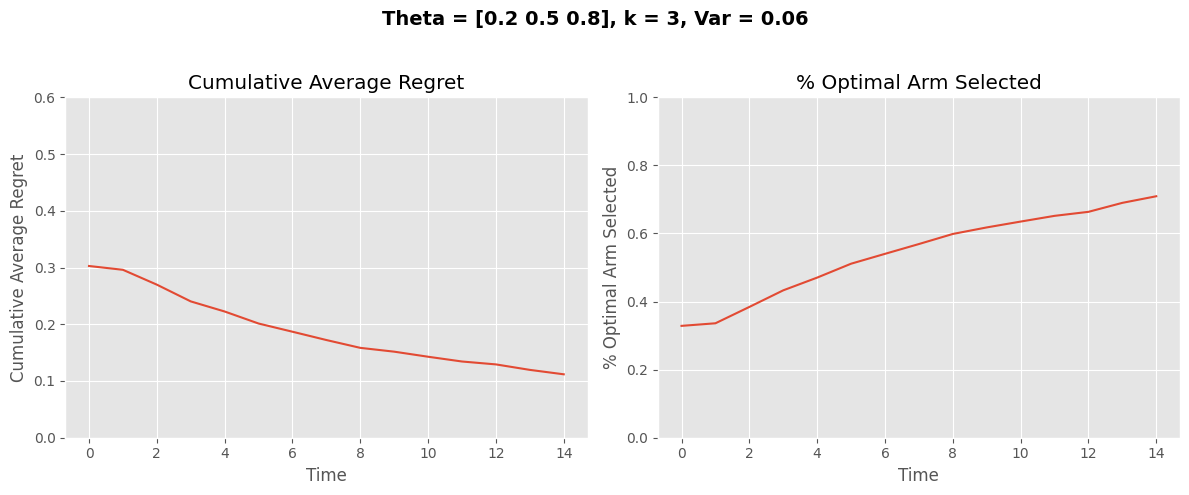

In [37]:
# Fix T and theta1. Let theta2 range in [0, 1].
T = 15
theta_1 = 0.5
theta_2 = np.array([.2,.5,.8])

TS_2 = average_thompson_path(theta_2, T)

plot_results(TS_2, theta_2, T)

# ------------------------------------------------------------------------------
T = 200
theta1  = .5
theta2s = np.linspace(0, 1, 21) # an array of length 21
thetas  = np.array([[theta1, theta2] for theta2 in theta2s])

# Compute the cumulative average regret for each theta2.
first_term  = np.max(thetas, axis=1)

# Iterating over the array of thetas, simulate Thompson sampling for each theta2.
second_term = [average_thompson_path(th, T)[2] for th in thetas] # average across simulation runs for each t
second_term = np.mean(second_term, axis=1) # average across t for each theta

# Compute the cumulative average regret for each theta2.
cum_avg_regret = first_term - second_term

# Create a plot with theta2 on the horizontal and regret on the vertical axis.
plt.plot(theta2s, cum_avg_regret)
#plt.ylim(bottom = 0)
plt.xlabel('$\\theta_2$')
plt.ylabel('regret $\\overline{R_T}$')
plt.title(f'Cumulative average regret of Thompsons sampling for different $\\theta_2$')


[the second peak over the distributions is due to weak signals, so they end at the wrong side of the arm.]

Your figure should have a sharp dip at 0.5. Why?

[thompson can converge at the wrong arm.]

[around the middle, it's hard to find regret]

## **Question 2:** Thompson sampling and exploration sampling

**Exploration sampling**, introduced by Kasy and Sautmann (2021), is a modification of Thompson sampling for settings in which a policy maker runs a pilot experiment on a subpopulation to explore different policy alternatives before implementing the best one in a full-scale policy roll-out. When the number of participants in the experiment is small, it is justifiable to only consider the social welfare of the policy choice $d^*_T$ for the full-scale implementation. Since the goal of the policy maker is to maximize the success rate of this *final policy choice*, there is no exploitation motive during the pilot. The exploration-exploitation trade-off typical for bandit settings is resolved by focusing exclusively on exploration. Exploration is achieved by adjusting the assignment probability of treatment $d$ at time $t$, $p_t^d$, from Thompson sampling by shifting weight from the best performing option to its close competitors. This improves power for comparing relevant alternatives.

### Exploration sampling
Consider $T$ waves of repeated cross-sections from the population of interest of size $N_t$ with units $i = 1, \ldots, N_t$. The total sample is $M = \sum_t N_t$. As before, $k$ treatments $D_{it} = 1, ..., k$ are available. Outcomes are binary and given by the potential outcomes equation $Y_{it} = \sum_{d=1}^k 1\{ D_i = d \} \cdot Y_{it}^d$. True average treatment effects are $\theta^d = E[Y^d_{it}]$. Treatment effects are independent across $d$, and potential outcomes satisfy SUTVA. Denote the number of units assigned to treatment $d$ at wave $t$ $$
\begin{aligned}
&n_t^d = \sum_i 1\{ D_{it} = d \}, & n_t = (n_t^1, \ldots, n^k_t), \\
& \sum_d n_t^d = N_t
\end{aligned}
$$ and the number of successes in wave $t$ for treatment $d$: $$
\begin{aligned}
&s_t^d = \sum_i 1\{ D_{it} = d, Y_{it} = 1 \}, & s_t = (s_t^1, \ldots, s^k_t), \\
& s_t^d \leq n_t^d
\end{aligned}
$$ and their cumulative outcomes from 1 to $t$ $$
\begin{aligned}
&m_t^d = \sum_{t^\prime \leq t} n_{t^\prime}^d, & r_t^d = \sum_{t^\prime \leq t} s_{t^\prime}^d
\end{aligned}
$$ As before consider the beta-binomial model with $Y_{it} \sim Ber(\theta^d)$ and the prior $\theta^d \sim Beta(\alpha_0^d, \beta_0^d)$. For a uniform prior, $\alpha_0^d = \beta_0^d = 1 \forall d$ as above. The posterior is $$
\begin{aligned}
\theta^d | m_t, r_t &\sim Beta(\alpha_t^d, \beta_t^d) \; \text{ where} \\
\alpha_t^d &= \alpha_{t-1}^d + s_t^d = \alpha_0^d + r_t^d \\
\beta_t^d &= \beta_{t-1}^d + n_t^d - s_t^d = \beta_0^d + m_t^d -r_t^d \\
\end{aligned}
$$ After the last wave $T$ the policy for the large-scale implementation is chosen to maximise *per-capita expected social welfare*, which is given by the mean of the final posterior: $$
SW_T(d) = E[\theta^d | m_T, r_T] = \frac{\alpha_0^d + r_T^d}{\alpha_0^d + \beta_0^d + m_T^d}
$$ Again, this resembles a shrinkage estimator. The *optimal policy choice* is the treatment with the highest posterior mean $$
d_T^* \in \arg \max_d SW_T(d)
$$ and the *true optimal policy choice* is $$
d^{(1)} \in \arg \max_{d^\prime} \theta^{d^\prime}
$$To evaluate the algorithm, we consider *policy regret* instead of in-sample regret (cumulative average regret) as before. Define policy regret as $\Delta^d := \theta^{d^{(1)}} - \theta^d$. *Expected policy regret* is the expected value of the policy regret for the final policy choice, conditional on the true treatment effects $\theta$: $$
R_\theta (T) = E[\Delta^{d^*_T} | \theta] = \sum_d \Delta^d P(d^*_T = d | \theta)
$$

Thompson sampling assigns treatment $d$ with the posterior probability that given past observed outcomes, $d$ is the optimal treatment: $$
p_t^d = P(d = \arg \max_{d^\prime} \theta^{d^\prime} | m_{t-1}, r_{t-1})
$$For the beta-binomial model, $\hat\theta$ is sampled from the posterior (see above). *Exploration sampling* replaces the *Thompson assignment shares* $(p^1_t, \ldots, p_t^k)$ with the transformed shares $q^d_t$: $$
\begin{aligned}
&q_t^d = S_t \cdot p_t^d(1-p_t^d), &S_t = \frac{1}{\sum_{d^\prime} p_t^{d^\prime} (1 - p_t^{d^\prime})}
\end{aligned}
$$Note that the mapping from $p_t^d$ to $q_t^d$ is increasing and convex in $p_t^d$, such that exploration sampling shifts weight from the best performing option to its close competitors compared to Thompson sampling.

We will implement and analyse exploration sampling and compare it to Thompson sampling.

### 2) a)

### 2) b)

### 2) c)

### 2) d)